In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Libraries**

In [1]:
try:
  from datasets import load_dataset
  from datasets import Dataset, DatasetDict
except Exception:
  !pip install datasets -q
  from datasets import load_dataset
  from datasets import Dataset, DatasetDict

try:
    import gensim.downloader as api
except:
    !pip install --upgrade gensim
    import gensim.downloader as api

import re
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from tqdm import tqdm

### **Load Dataset**

In [2]:
def stars_to_sentiment(star_rate: int) -> str:
    """
    Converts the star rating of a review to a sentiment.

    Parameters:
    star_rate (int): The star rating of the review. It should be an integer.

    Returns:
    str: The sentiment corresponding to the star rating:
         - "NEG" for negative sentiment (star rating less than 2)
         - "NEU" for neutral sentiment (star rating equal to 2)
         - "POS" for positive sentiment (star rating greater than 2)
    """
    match star_rate:
        case _ if star_rate < 2:
            return "NEG"
        case _ if star_rate == 2:
            return "NEU"
        case _ if star_rate > 2:
            return "POS"

In [3]:
dataset = load_dataset('yelp_review_full')

train_dataset = dataset['train']
test_dataset  = dataset['test']
del dataset

train_text  = [train_dataset[i]['text'] for i in range(len(train_dataset))]
train_label = [train_dataset[i]['label'] for i in range(len(train_dataset))]
train_text  = [text for text, label in zip(train_text, train_label) if label != 2]
train_label = [label for label in train_label if label != 2]

test_text  = [test_dataset[i]['text'] for i in range(len(test_dataset))]
test_label = [test_dataset[i]['label'] for i in range(len(test_dataset))]
test_text  = [text for text, label in zip(test_text, test_label) if label != 2]
test_label = [label for label in test_label if label != 2]

train_label = [stars_to_sentiment(label) for label in train_label]
test_label  = [stars_to_sentiment(label) for label in test_label]

del train_dataset
del test_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Split training data into two sets, named training and validations set in order to preventing overfiting

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_text, train_label, test_size = 0.3, shuffle = True, stratify = train_label, random_state = 42
)

len(y_train), len(y_valid), len(test_label)

(364000, 156000, 40000)

In [5]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_train, y_train)]
validation_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_valid, y_valid)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_text, test_label)]

# Convert to huggingface dataset api
train_data = Dataset.from_list(train_data)
validation_data = Dataset.from_list(validation_data)
test_data = Dataset.from_list(test_data)

data = DatasetDict()
data['train'] = train_data
data['validation'] = validation_data
data['test'] = test_data

In [6]:
label2id = {'NEG': 0, 'POS': 1}
id2label = {0: 'NEG', 1: 'POS'}

In [7]:
# Define the mapping function
def map_labels(example: dict):
    example['labels'] = [label2id[label] for label in example['label']]
    return example

data = data.map(map_labels, batched = True)
data = data.remove_columns(['label'])

Map:   0%|          | 0/364000 [00:00<?, ? examples/s]

Map:   0%|          | 0/156000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

### **Sentiment Analysis with CountVectorizer + Naive Bayes**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB


# Define the pipeline
pipeline = Pipeline([
    ('countV', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'countV__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'nb': [MultinomialNB(), BernoulliNB(), ComplementNB()]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 1, scoring = 'accuracy')

# Fit the model
grid_search.fit(data['train']['text'], data['train']['labels'])


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countV', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'countV__max_features': [1000, 2000, 3000, 4000, 5000],
                         'nb': [MultinomialNB(), BernoulliNB(),
                                ComplementNB()]},
             scoring='accuracy', verbose=1)

In [ ]:
import pandas as pd


df_cv_results_countV = pd.DataFrame(grid_search.cv_results_)[['param_countV__max_features', 'param_nb', 'mean_test_score']]
df_cv_results_countV['param_nb'] = df_cv_results_countV['param_nb'].astype(str)
df_cv_results_countV.sort_values(by = ['param_countV__max_features', 'param_nb'], inplace = True)
df_cv_results_countV

,param_countV__max_features,param_nb,mean_test_score
1,1000,BernoulliNB(),0.708953
2,1000,ComplementNB(),0.837093
0,1000,MultinomialNB(),0.837093
4,2000,BernoulliNB(),0.725047
5,2000,ComplementNB(),0.850140
3,2000,MultinomialNB(),0.850140
7,3000,BernoulliNB(),0.731967
8,3000,ComplementNB(),0.854942
6,3000,MultinomialNB(),0.854942
10,4000,BernoulliNB(),0.737225


In [ ]:
from sklearn.metrics import classification_report



# Access the best model
best_cv_nb_model = grid_search.best_estimator_

preds_cv_nb = best_cv_nb_model.predict(data['validation']['text'])

print(classification_report(data['validation']['labels'], preds_cv_nb, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.8868    0.8271    0.8559     78000
         POS     0.8380    0.8945    0.8653     78000

    accuracy                         0.8608    156000
   macro avg     0.8624    0.8608    0.8606    156000
weighted avg     0.8624    0.8608    0.8606    156000



In [ ]:
# Access the best model
best_cv_nb_model = grid_search.best_estimator_

preds_cv_nb = best_cv_nb_model.predict(data['test']['text'])

print(classification_report(data['test']['labels'], preds_cv_nb, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.8871    0.8303    0.8577     20000
         POS     0.8405    0.8943    0.8666     20000

    accuracy                         0.8623     40000
   macro avg     0.8638    0.8623    0.8622     40000
weighted avg     0.8638    0.8623    0.8622     40000



### **Comparing the Naive Bayes Models Performance**

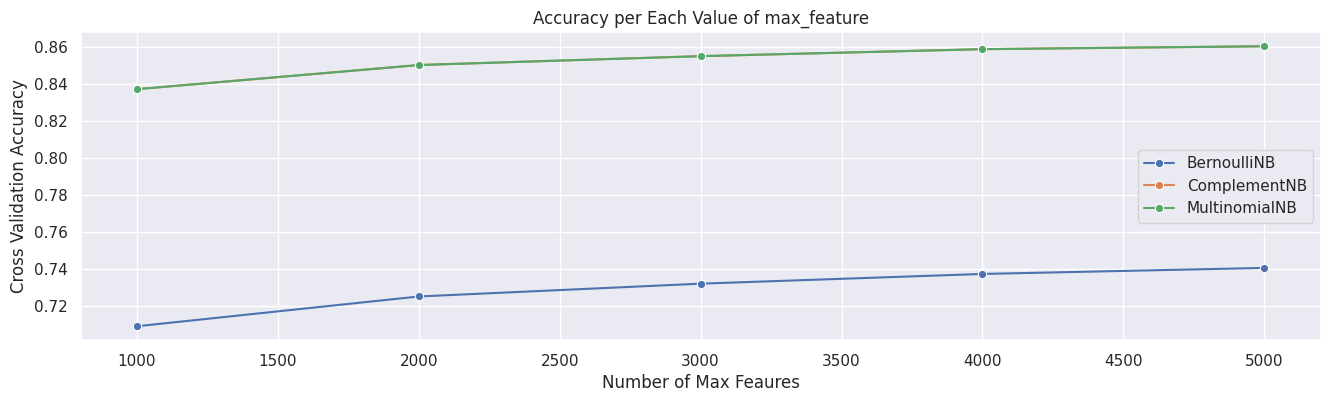

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(16, 4))
sns.set_theme()


for nb in df_cv_results_countV['param_nb'].unique():
    df_filtered = df_cv_results_countV[
        (df_cv_results_countV['param_nb'] == nb)
    ]

    sns.lineplot(
        df_filtered,
        x = 'param_countV__max_features',
        y = 'mean_test_score',
        label = nb[:-2],
        marker = 'o'
    )

plt.title("Accuracy per Each Value of max_feature")
plt.xlabel("Number of Max Feaures")
plt.ylabel("Cross Validation Accuracy")

plt.show()

ComplementNB results are exactly same as MultinomialNB. This is why, in the visualization we can see only two Naive Bayes model.

### **Sentiment Analysis with CountVectorizer + Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression



# Define the steps in the pipeline
steps = [
    ('countV', CountVectorizer(stop_words = 'english')), # Step 1: TF-IDF vectorization for text data
    ('logistic', LogisticRegression(max_iter = 250)) # Step 2: Logistic Regression classifier
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "countV__max_features": [1_000, 2_000, 3_000, 4_000, 5_000, 6_000],
}

# Instantiate the GridSearchCV object with scoring parameter
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 1, scoring = 'accuracy')

# Fit the grid search to the data
grid_search.fit(data['train']['text'], data['train']['labels'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countV',
                                        CountVectorizer(stop_words='english')),
                                       ('logistic',
                                        LogisticRegression(max_iter=250))]),
             param_grid={'countV__max_features': [1000, 2000, 3000, 4000, 5000,
                                                  6000]},
             scoring='accuracy', verbose=1)

In [ ]:
df_cv_results_countV = pd.DataFrame(grid_search.cv_results_)[['param_countV__max_features', 'mean_test_score']]
df_cv_results_countV

,param_countV__max_features,mean_test_score
0,1000,0.893440
1,2000,0.908654
2,3000,0.914247
3,4000,0.917206
4,5000,0.918626
5,6000,0.919236


In [ ]:
# Access the best model
best_countV_logistic_model = grid_search.best_estimator_

preds_countV_logistic = best_countV_logistic_model.predict(data['validation']['text'])

print(classification_report(data['validation']['labels'], preds_countV_logistic, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.9276    0.9148    0.9212     78000
         POS     0.9160    0.9286    0.9223     78000

    accuracy                         0.9217    156000
   macro avg     0.9218    0.9217    0.9217    156000
weighted avg     0.9218    0.9217    0.9217    156000



In [ ]:
preds_countV_logistic = best_countV_logistic_model.predict(data['test']['text'])

print(classification_report(data['test']['labels'], preds_countV_logistic, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.9265    0.9126    0.9195     20000
         POS     0.9139    0.9276    0.9207     20000

    accuracy                         0.9201     40000
   macro avg     0.9202    0.9201    0.9201     40000
weighted avg     0.9202    0.9201    0.9201     40000



### **Sentiment Analysis with TFIDF + Logistic Regression**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer



# Define the steps in the pipeline
steps = [
    ('tfidf', TfidfVectorizer(stop_words = 'english')), # Step 1: TF-IDF vectorization for text data
    ('logistic', LogisticRegression(max_iter = 250)) # Step 2: Logistic Regression classifier
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "tfidf__max_features": [1_000, 2_000, 3_000, 4_000, 5_000, 6_000],
}

# Instantiate the GridSearchCV object with scoring parameter
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 1, scoring = 'accuracy')

# Fit the grid search to the data
grid_search.fit(data['train']['text'], data['train']['labels'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logistic',
                                        LogisticRegression(max_iter=250))]),
             param_grid={'tfidf__max_features': [1000, 2000, 3000, 4000, 5000,
                                                 6000]},
             scoring='accuracy', verbose=1)

In [ ]:
df_cv_results_tfidf = pd.DataFrame(grid_search.cv_results_)[['param_tfidf__max_features', 'mean_test_score']]
df_cv_results_tfidf

,param_tfidf__max_features,mean_test_score
0,1000,0.894723
1,2000,0.909898
2,3000,0.915846
3,4000,0.919047
4,5000,0.920907
5,6000,0.921931


In [ ]:
# Access the best model
best_tfidf_logistic_model = grid_search.best_estimator_

preds_tfidf_logistic = best_tfidf_logistic_model.predict(data['validation']['text'])

print(classification_report(data['validation']['labels'], preds_tfidf_logistic, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.9256    0.9211    0.9234     78000
         POS     0.9215    0.9260    0.9237     78000

    accuracy                         0.9236    156000
   macro avg     0.9236    0.9236    0.9236    156000
weighted avg     0.9236    0.9236    0.9236    156000



In [ ]:
preds_tfidf_logistic = best_tfidf_logistic_model.predict(data['test']['text'])

print(classification_report(data['test']['labels'], preds_tfidf_logistic, target_names = ['NEG', 'POS'], digits = 4))

              precision    recall  f1-score   support

         NEG     0.9246    0.9201    0.9224     20000
         POS     0.9205    0.9250    0.9227     20000

    accuracy                         0.9225     40000
   macro avg     0.9226    0.9225    0.9225     40000
weighted avg     0.9226    0.9225    0.9225     40000



### **Comparing the Results of TFIDF and CountVectorizer**

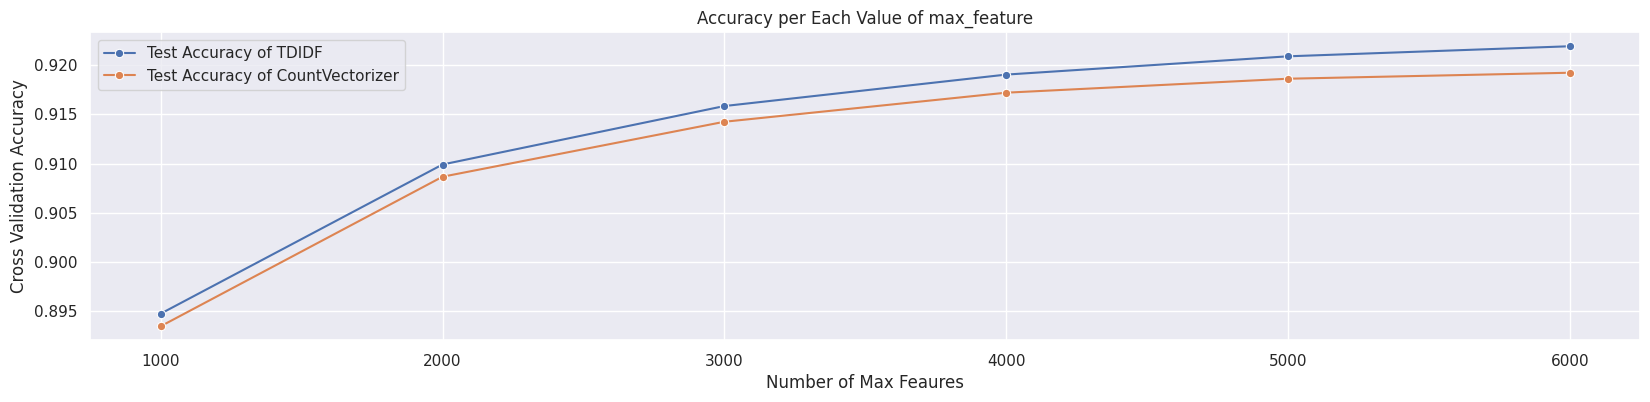

In [ ]:
plt.figure(figsize=(20, 4))

sns.set_theme()

sns.lineplot(
    df_cv_results_tfidf,
    x = 'param_tfidf__max_features',
    y = 'mean_test_score',
    label = 'Test Accuracy of TDIDF',
    marker = 'o'
)

sns.lineplot(
    df_cv_results_countV,
    x = 'param_countV__max_features',
    y = 'mean_test_score',
    label = 'Test Accuracy of CountVectorizer',
    marker = 'o'
)

plt.title("Accuracy per Each Value of max_feature")
plt.xlabel("Number of Max Feaures")
plt.ylabel("Cross Validation Accuracy")

plt.show()

### **Sentiment Analysis with GloVe + Logistic Regression**

Load the pretrained GloVe model

In [8]:
model_twitter = api.load("glove-twitter-50")
model_wiki = api.load("glove-wiki-gigaword-50")

Vectorize the training and testing texts in order to provide them as inputs for Logistic Regression.

In [9]:
import string
import numpy as np


def vectorize(docs, embedding_model, useSum = True, embedding_size = 50):

    regex = '[' + string.punctuation + ']'
    vectors = np.zeros((len(docs), embedding_size))

    for i in tqdm(range(len(docs))):
        tokens = re.sub(regex, '', docs[i].lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)

    return vectors

In [23]:
# find all possible embedding approaches
embedding_1 = vectorize(data['train']['text'], model_twitter, useSum = True)
embedding_2 = vectorize(data['train']['text'], model_twitter, useSum = False)
embedding_3 = vectorize(data['train']['text'], model_wiki, useSum = True)
embedding_4 = vectorize(data['train']['text'], model_wiki, useSum = False)

100%|██████████| 364000/364000 [02:57<00:00, 2052.38it/s]


Fit Logistic Regression whose input is Word2Vec embedding on training data.

In [24]:
from sklearn.linear_model import LogisticRegression



models = []
for embedding_approach in tqdm([embedding_1, embedding_2, embedding_3, embedding_4]):
    glove_logistic_model = LogisticRegression(max_iter = 1_000)
    glove_logistic_model.fit(embedding_approach, data['train']['labels'])

    models.append(glove_logistic_model)


del embedding_1
del embedding_2
del embedding_3
del embedding_4

100%|██████████| 4/4 [02:56<00:00, 44.20s/it]


In [25]:
def evaluate_on_testing_set(testing_texts, testing_labels, classifier_model, embedding_model, useSum=True):
    embeddings = vectorize(testing_texts, embedding_model, useSum)
    preds = classifier_model.predict(embeddings)
    report = classification_report(testing_labels, preds, target_names=['NEG', 'POS'], digits=4)
    print(report)

In [26]:
evaluate_on_testing_set(
    data['test']['text'], data['test']['labels'], models[0], model_twitter, useSum = True
)

100%|██████████| 40000/40000 [00:19<00:00, 2009.80it/s]


              precision    recall  f1-score   support

         NEG     0.8421    0.8255    0.8337     20000
         POS     0.8288    0.8452    0.8369     20000

    accuracy                         0.8353     40000
   macro avg     0.8355    0.8353    0.8353     40000
weighted avg     0.8355    0.8353    0.8353     40000



In [27]:
evaluate_on_testing_set(
    data['test']['text'], data['test']['labels'], models[1], model_twitter, useSum = False
)

100%|██████████| 40000/40000 [00:20<00:00, 1945.83it/s]


              precision    recall  f1-score   support

         NEG     0.8269    0.8496    0.8381     20000
         POS     0.8454    0.8222    0.8336     20000

    accuracy                         0.8359     40000
   macro avg     0.8361    0.8359    0.8358     40000
weighted avg     0.8361    0.8359    0.8358     40000



In [28]:
evaluate_on_testing_set(
    data['test']['text'], data['test']['labels'], models[2], model_wiki, useSum = True
)

100%|██████████| 40000/40000 [00:20<00:00, 1977.32it/s]


              precision    recall  f1-score   support

         NEG     0.8151    0.7812    0.7978     20000
         POS     0.7900    0.8228    0.8061     20000

    accuracy                         0.8020     40000
   macro avg     0.8025    0.8020    0.8019     40000
weighted avg     0.8025    0.8020    0.8019     40000



In [29]:
evaluate_on_testing_set(
    data['test']['text'], data['test']['labels'], models[3], model_wiki, useSum = False
)

100%|██████████| 40000/40000 [00:19<00:00, 2073.52it/s]


              precision    recall  f1-score   support

         NEG     0.7966    0.8185    0.8074     20000
         POS     0.8134    0.7910    0.8020     20000

    accuracy                         0.8047     40000
   macro avg     0.8050    0.8048    0.8047     40000
weighted avg     0.8050    0.8047    0.8047     40000



### **Sentiment Analysis with DistilBERT**

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def preprocess_function(examples: dict):
    return tokenizer(examples['text'], truncation = True, padding = True, max_length = 128, return_tensors = "tf")

tokenized_data = data.map(preprocess_function, batched = True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/364000 [00:00<?, ? examples/s]

Map:   0%|          | 0/156000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

fine-tune the baseline model on our training set

In [ ]:
# Load the pre-trained model without changing the number of labels
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = len(set(train_label))
)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
model.config.label2id = label2id
model.config.id2label = id2label


In [ ]:
batch_size = 64

train_data = tokenized_data['train'].to_tf_dataset(
        columns    = ['input_ids', 'attention_mask'],
        label_cols = ['labels'],
        shuffle    = True,
        batch_size = batch_size,
).prefetch(buffer_size = tf.data.AUTOTUNE)

valid_data = tokenized_data['validation'].to_tf_dataset(
        columns    = ['input_ids', 'attention_mask'],
        label_cols = ['labels'],
        shuffle    = True,
        batch_size = batch_size,
).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = tokenized_data['test'].to_tf_dataset(
        columns    = ['input_ids', 'attention_mask'],
        label_cols = ['labels'],
        batch_size = batch_size,
).prefetch(buffer_size = tf.data.AUTOTUNE)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/checkpoint.keras",
        verbose=0,
        save_best_only=True,
        save_freq='epoch',
    )
]

# Train the model
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 5,
    callbacks = callbacks,
)

Epoch 1/5
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1716465987.920799     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5688/5688 [==============================] - ETA: 0s - loss: 0.1712 - sparse_categorical_accuracy: 0.9316

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


5688/5688 [==============================] - 2934s 506ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.9316 - val_loss: 0.1409 - val_sparse_categorical_accuracy: 0.9458
Epoch 2/5
5688/5688 [==============================] - 2884s 507ms/step - loss: 0.1177 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.1284 - val_sparse_categorical_accuracy: 0.9502
Epoch 3/5
5688/5688 [==============================] - 2882s 507ms/step - loss: 0.0881 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.1326 - val_sparse_categorical_accuracy: 0.9506
Epoch 4/5
5688/5688 [==============================] - 2879s 506ms/step - loss: 0.0639 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.1453 - val_sparse_categorical_accuracy: 0.9503
Epoch 5/5
5688/5688 [==============================] - 2881s 506ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.1597 - val_sparse_categorical_accuracy: 0.9492


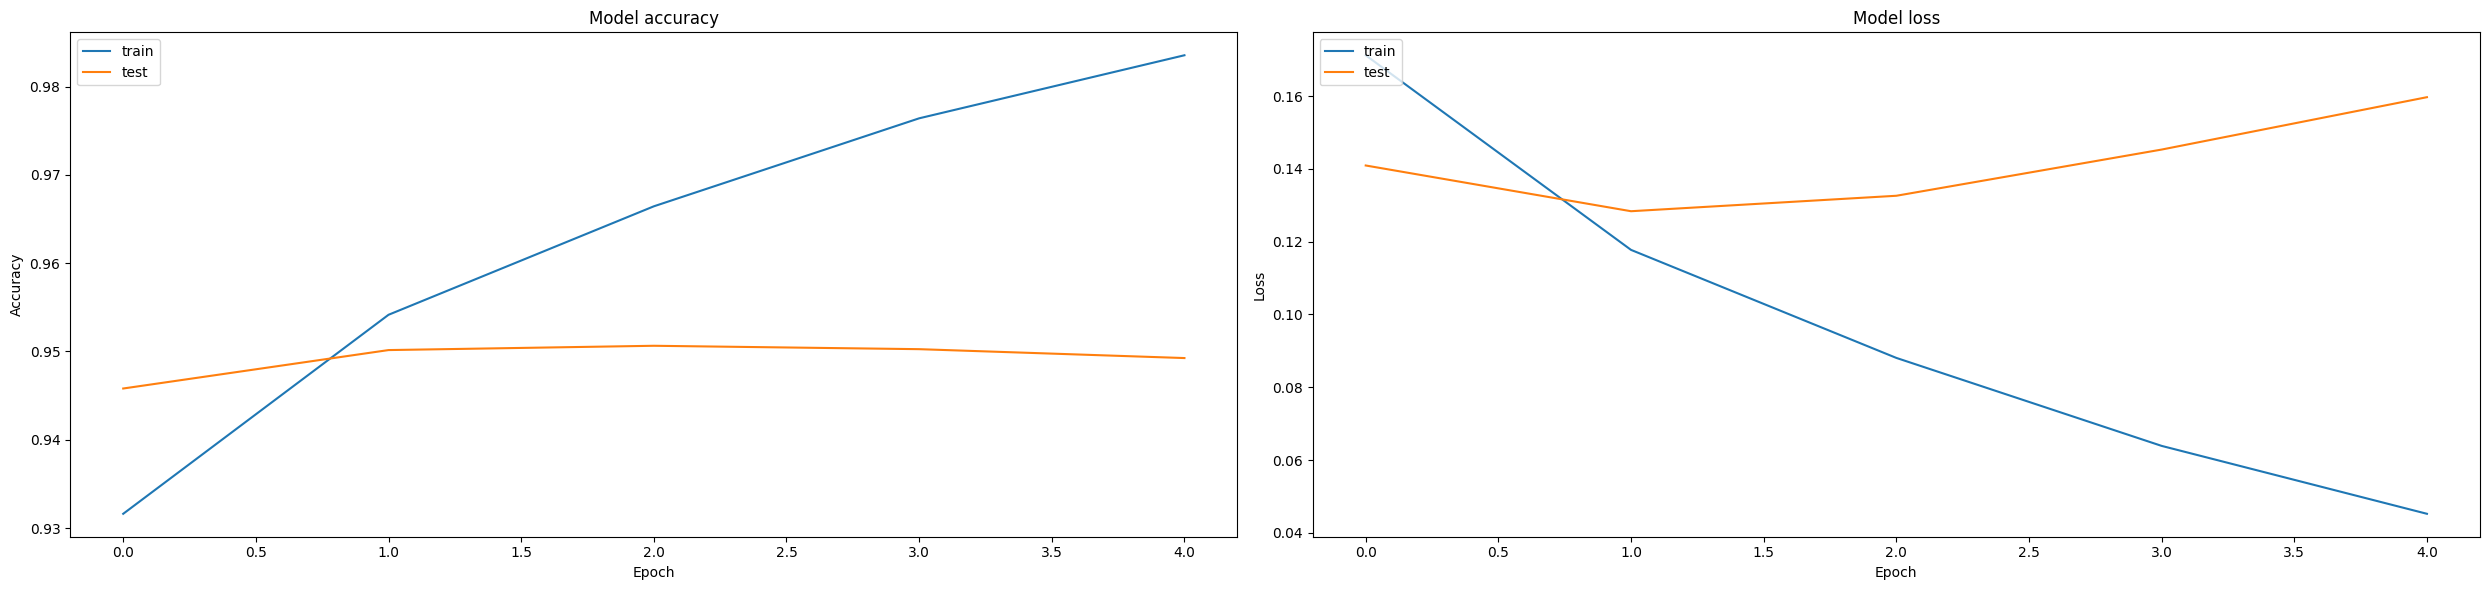

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(25, 6))

# Plot accuracy
axs[0].plot(history.history['sparse_categorical_accuracy'])
axs[0].plot(history.history['val_sparse_categorical_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper left')

# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'test'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
model.load_weights(
    "/content/drive/MyDrive/checkpoint.keras",
    by_name=True,
    skip_mismatch=True
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
model.evaluate(test_data)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
625/625 [==============================] - 197s 270ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9518


[0.1236446425318718, 0.9517999887466431]